In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from torchvision.utils import save_image

from tqdm.notebook import tqdm
import torch.nn.functional as F
from PIL import Image
import os
import PIL
from  torch.optim.lr_scheduler import StepLR


In [2]:
DATA_DIR = "/home/tushar-choudhary/projects/animeGANS/data/"
dir_list= os.listdir(DATA_DIR+"cropped")
for i in dir_list:
    try:
        ok = Image.open(DATA_DIR+"cropped/"+i)
    except PIL.UnidentifiedImageError:
        os.remove(DATA_DIR+"cropped/"+i)

In [3]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)



In [4]:
transforms = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_ds = ImageFolder(DATA_DIR,transform=transforms)
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)


In [5]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

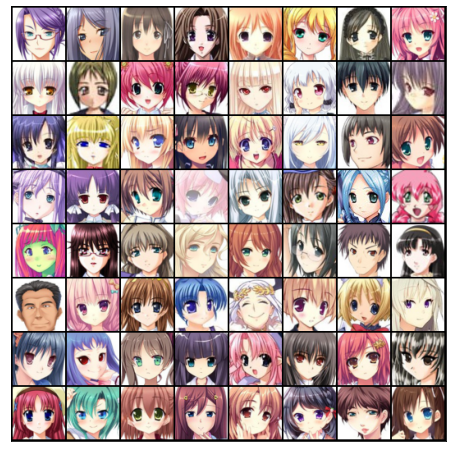

In [6]:
show_batch(train_dl)


In [7]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [8]:
device= torch.device('cuda')
train_dl = DeviceDataLoader(train_dl, device)

In [9]:
discriminator = nn.Sequential(
    

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),


    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    
    nn.Flatten(),
    nn.Sigmoid())

In [10]:
latent_size = 128


In [11]:
generator = nn.Sequential(
   

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),


    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),


    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),


    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


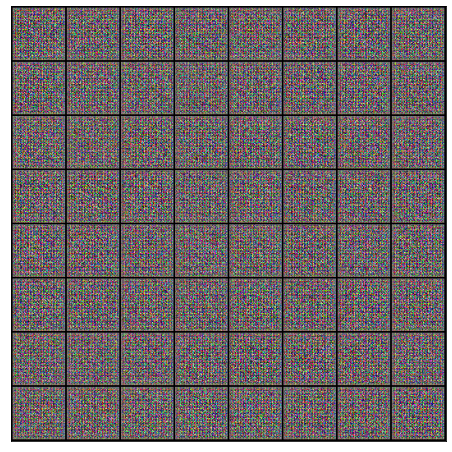

In [12]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [13]:
generator,discriminator = generator.cuda(),discriminator.cuda()

In [14]:
def train_generator(opt_g):
    opt_g.zero_grad()
    
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    
    loss.backward()
    opt_g.step()
    
    return loss.item()
    

In [15]:
def train_discriminator(real_images, opt_d):
    
    opt_d.zero_grad()

    
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [16]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    scheduler_d = StepLR(opt_d, step_size=30, gamma=0.1)
    scheduler_g = StepLR(opt_g, step_size=30, gamma=0.1)
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
        scheduler_g.step()
        scheduler_d.step()
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [17]:
lr = 0.0004
epochs = 25

In [18]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Saving generated-images-0000.png


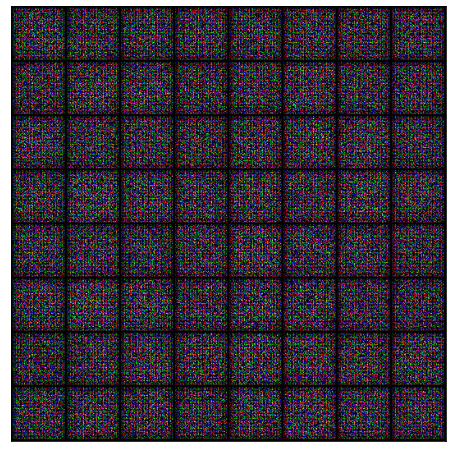

In [19]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)


In [20]:
history = fit(epochs, lr)



Epoch [1/25], loss_g: 4.0581, loss_d: 0.6583, real_score: 0.6325, fake_score: 0.0750
Saving generated-images-0001.png



Epoch [2/25], loss_g: 5.9607, loss_d: 0.2124, real_score: 0.9317, fake_score: 0.1215
Saving generated-images-0002.png



Epoch [3/25], loss_g: 4.2066, loss_d: 0.4471, real_score: 0.7040, fake_score: 0.0211
Saving generated-images-0003.png



Epoch [4/25], loss_g: 5.6593, loss_d: 0.1388, real_score: 0.9243, fake_score: 0.0503
Saving generated-images-0004.png



Epoch [5/25], loss_g: 5.1837, loss_d: 0.1795, real_score: 0.9253, fake_score: 0.0838
Saving generated-images-0005.png



Epoch [6/25], loss_g: 7.0880, loss_d: 0.7678, real_score: 0.5781, fake_score: 0.0006
Saving generated-images-0006.png



Epoch [7/25], loss_g: 5.1104, loss_d: 0.1271, real_score: 0.9132, fake_score: 0.0112
Saving generated-images-0007.png



Epoch [8/25], loss_g: 4.1994, loss_d: 0.4774, real_score: 0.7620, fake_score: 0.0245
Saving generated-images-0008.png



Epoch [9/25], loss_g: 12.1311, loss_d: 0.5443, real_score: 0.9857, fake_score: 0.3462
Saving generated-images-0009.png



Epoch [10/25], loss_g: 9.6447, loss_d: 0.3824, real_score: 0.9835, fake_score: 0.2564
Saving generated-images-0010.png



Epoch [11/25], loss_g: 5.3562, loss_d: 0.1768, real_score: 0.9275, fake_score: 0.0833
Saving generated-images-0011.png



Epoch [12/25], loss_g: 4.7179, loss_d: 0.1350, real_score: 0.9329, fake_score: 0.0501
Saving generated-images-0012.png



Epoch [13/25], loss_g: 5.9192, loss_d: 0.0984, real_score: 0.9576, fake_score: 0.0469
Saving generated-images-0013.png



Epoch [14/25], loss_g: 6.7240, loss_d: 0.0567, real_score: 0.9841, fake_score: 0.0363
Saving generated-images-0014.png



Epoch [15/25], loss_g: 4.0649, loss_d: 0.1415, real_score: 0.9146, fake_score: 0.0404
Saving generated-images-0015.png



Epoch [16/25], loss_g: 4.3712, loss_d: 0.0885, real_score: 0.9793, fake_score: 0.0593
Saving generated-images-0016.png



Epoch [17/25], loss_g: 5.0279, loss_d: 0.5710, real_score: 0.6738, fake_score: 0.0070
Saving generated-images-0017.png



Epoch [18/25], loss_g: 5.8734, loss_d: 0.2198, real_score: 0.9098, fake_score: 0.0673
Saving generated-images-0018.png



Epoch [19/25], loss_g: 5.7328, loss_d: 0.1200, real_score: 0.9859, fake_score: 0.0933
Saving generated-images-0019.png



Epoch [20/25], loss_g: 5.1237, loss_d: 0.1635, real_score: 0.8938, fake_score: 0.0204
Saving generated-images-0020.png



Epoch [21/25], loss_g: 5.3921, loss_d: 0.1373, real_score: 0.9763, fake_score: 0.0971
Saving generated-images-0021.png



Epoch [22/25], loss_g: 4.9284, loss_d: 0.0826, real_score: 0.9843, fake_score: 0.0597
Saving generated-images-0022.png



Epoch [23/25], loss_g: 3.8840, loss_d: 0.1092, real_score: 0.9664, fake_score: 0.0653
Saving generated-images-0023.png



Epoch [24/25], loss_g: 4.3836, loss_d: 0.0839, real_score: 0.9623, fake_score: 0.0410
Saving generated-images-0024.png



Epoch [25/25], loss_g: 5.8169, loss_d: 0.1877, real_score: 0.9876, fake_score: 0.1478
Saving generated-images-0025.png


In [23]:
losses_g, losses_d, real_scores, fake_scores = history


In [24]:
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [26]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()


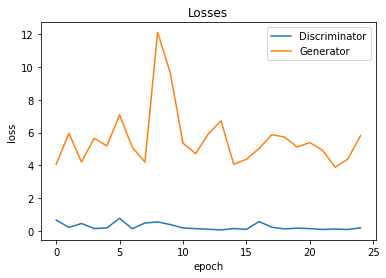

In [27]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

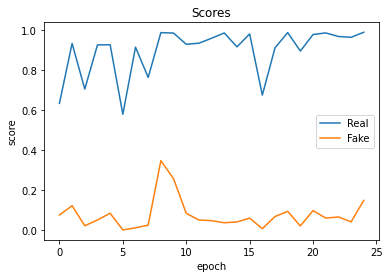

In [28]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');